In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.pylab as pylab
from labellines import labelLine, labelLines  # will first need to install labellines package

seedno = 12345
rng = np.random.default_rng(seed=seedno)

In [2]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
resolution_value = 100

## Model parameters

In [3]:
sigma = 0.01
S0 = 100.
T = 30.
lambda_a = 0.5
lambda_b = 0.5  # we test 0.5 and 0.45 and 0.2
qmax = 5
qmin = -qmax
sigma_Z = 1. # standard is 1.0, alternative is 0.0
kappa = 100.
# Model for misses
alpha_a = 0.001
alpha_b = 0.001
beta = 0.001   # standard is beta=0.001, alternative is beta = 0.005. Note model is extremely sensitive to beta

# Penalties
phi = 1e-3  # standard is phi=1e-4, alternative is phi=1e^-3
a = 1e-3

# changes font in plots
fontnm = "Times New Roman" 
tnrfont = {'fontname':fontnm} 

In [4]:
all_inventories = np.arange(qmax, qmin-1, step = -1)

## Implementation

In [5]:
A_matrix = np.zeros((2*qmax+1,2*qmax+1))
z_vector = np.zeros((2*qmax+1,1))

for i in range(2*qmax+1):
    inventory = qmax - i
    A_matrix[i, i] = - phi * kappa * inventory**2 - beta*(lambda_a+lambda_b)/2
    z_vector[i, 0] = np.exp(- a * kappa * inventory**2)
    if i + 1 < (2*qmax+1):
        A_matrix[i, i + 1] = lambda_b * np.exp(-1.+kappa*alpha_b + kappa*beta/2)
    if i > 0:
        A_matrix[i, i - 1] = lambda_a * np.exp(-1.+kappa*alpha_a + kappa*beta/2)

#print(A_matrix)

In [6]:
def _calculate_omega_t(t):
    return np.matmul(expm(A_matrix * (T - t) - beta*(lambda_a-lambda_b)**2*(T**2-t**2)/2*np.identity(2*qmax+1)) , z_vector)

In [7]:
def _calculate_gt(t):
    omega_function = _calculate_omega_t(t)
    return (1 / kappa) * np.log(omega_function)

def _calculate_ft(t):
    return beta*(lambda_a - lambda_b)*t

In [8]:
gt = _calculate_gt(0.5)
#print(gt)

In [9]:
def _old_calculate_deltas(t, q, d_plus_z, take_maximum = False):    
    delta_tilde_a = alpha_a + beta * (d_plus_z)
    delta_tilde_b = alpha_a - beta * (d_plus_z)
    g_qs  = _calculate_gt(t)
    
    ft = _calculate_ft(t)
    dz_minus_one = ft*(d_plus_z-1) - beta/2*(d_plus_z-1)**2
    dz_same = ft*(d_plus_z) - beta/2*(d_plus_z)**2
    dz_plus_one = ft*(d_plus_z+1) - beta/2*(d_plus_z+1)**2
    indices = np.clip(qmax - q, 0, 2 * qmax)
    indices = indices.astype(int)
    indices_minus_one = np.clip(indices - 1, 0, 2 * qmax)
    indices_plus_one = np.clip(indices + 1, 0, 2 * qmax)
    
    h_q_minus_one = np.squeeze(g_qs[indices_minus_one]) + dz_same
    h_d_minus_one = np.squeeze(g_qs[indices])+ dz_minus_one
    
    h_q_plus_one = np.squeeze(g_qs[indices_plus_one]) + dz_same
    h_d_plus_one = np.squeeze(g_qs[indices])+ dz_plus_one
    
    delta_hat_a = 1/kappa - h_q_minus_one + h_d_minus_one
    delta_hat_b = 1/kappa - h_q_plus_one + h_d_plus_one
    
    if take_maximum:
        delta_a = np.maximum(delta_hat_a, delta_tilde_a)
        delta_b = np.maximum(delta_hat_b, delta_tilde_b)
        return delta_a, delta_b
    else:
        return delta_hat_a, delta_hat_b

In [10]:
def _calculate_deltas(t, q, d_plus_z, take_maximum = False):    
    delta_tilde_a = alpha_a + beta * (d_plus_z)
    delta_tilde_b = alpha_a - beta * (d_plus_z)
    g_qs  = _calculate_gt(t)
    
    ft = _calculate_ft(t)
    dz_minus_one = ft*(d_plus_z-1) - beta/2*(d_plus_z-1)**2
    dz_same = ft*(d_plus_z) - beta/2*(d_plus_z)**2
    dz_plus_one = ft*(d_plus_z+1) - beta/2*(d_plus_z+1)**2
    indices = np.clip(qmax - q, 0, 2 * qmax)
    indices = indices.astype(int)
    indices_minus_one = np.clip(indices + 1, 0, 2 * qmax)  # moving up an index corresponds to lower inventory
    indices_plus_one = np.clip(indices - 1, 0, 2 * qmax) # moving down an index corresponds to higher inventory
    
    h_q_minus_one = np.squeeze(g_qs[indices_minus_one]) + dz_same
    h_d_minus_one = np.squeeze(g_qs[indices])+ dz_minus_one
    
    h_q_plus_one = np.squeeze(g_qs[indices_plus_one]) + dz_same
    h_d_plus_one = np.squeeze(g_qs[indices])+ dz_plus_one
    
    delta_hat_a = 1/kappa - h_q_minus_one + h_d_minus_one
    delta_hat_b = 1/kappa - h_q_plus_one + h_d_plus_one
    
    if take_maximum:
        delta_a = np.maximum(delta_hat_a, delta_tilde_a)
        delta_b = np.maximum(delta_hat_b, delta_tilde_b)
        return delta_a, delta_b
    else:
        return delta_hat_a, delta_hat_b

# Numerics

In [11]:
t = 0.5
d_plus_z = 0

q_vector = np.arange(qmax-1,qmin,step=-1)

deltas_a = np.zeros((q_vector.shape))
deltas_b = np.zeros((q_vector.shape))

for i,q in enumerate(q_vector):
    delta_a, delta_b = _calculate_deltas(t, q, d_plus_z)
    deltas_a[i] = delta_a
    deltas_b[i] = delta_b
print(deltas_a)

[-0.01219843 -0.0074449  -0.0016012   0.00554511  0.01345489  0.0206012
  0.0264449   0.03119843  0.035184  ]


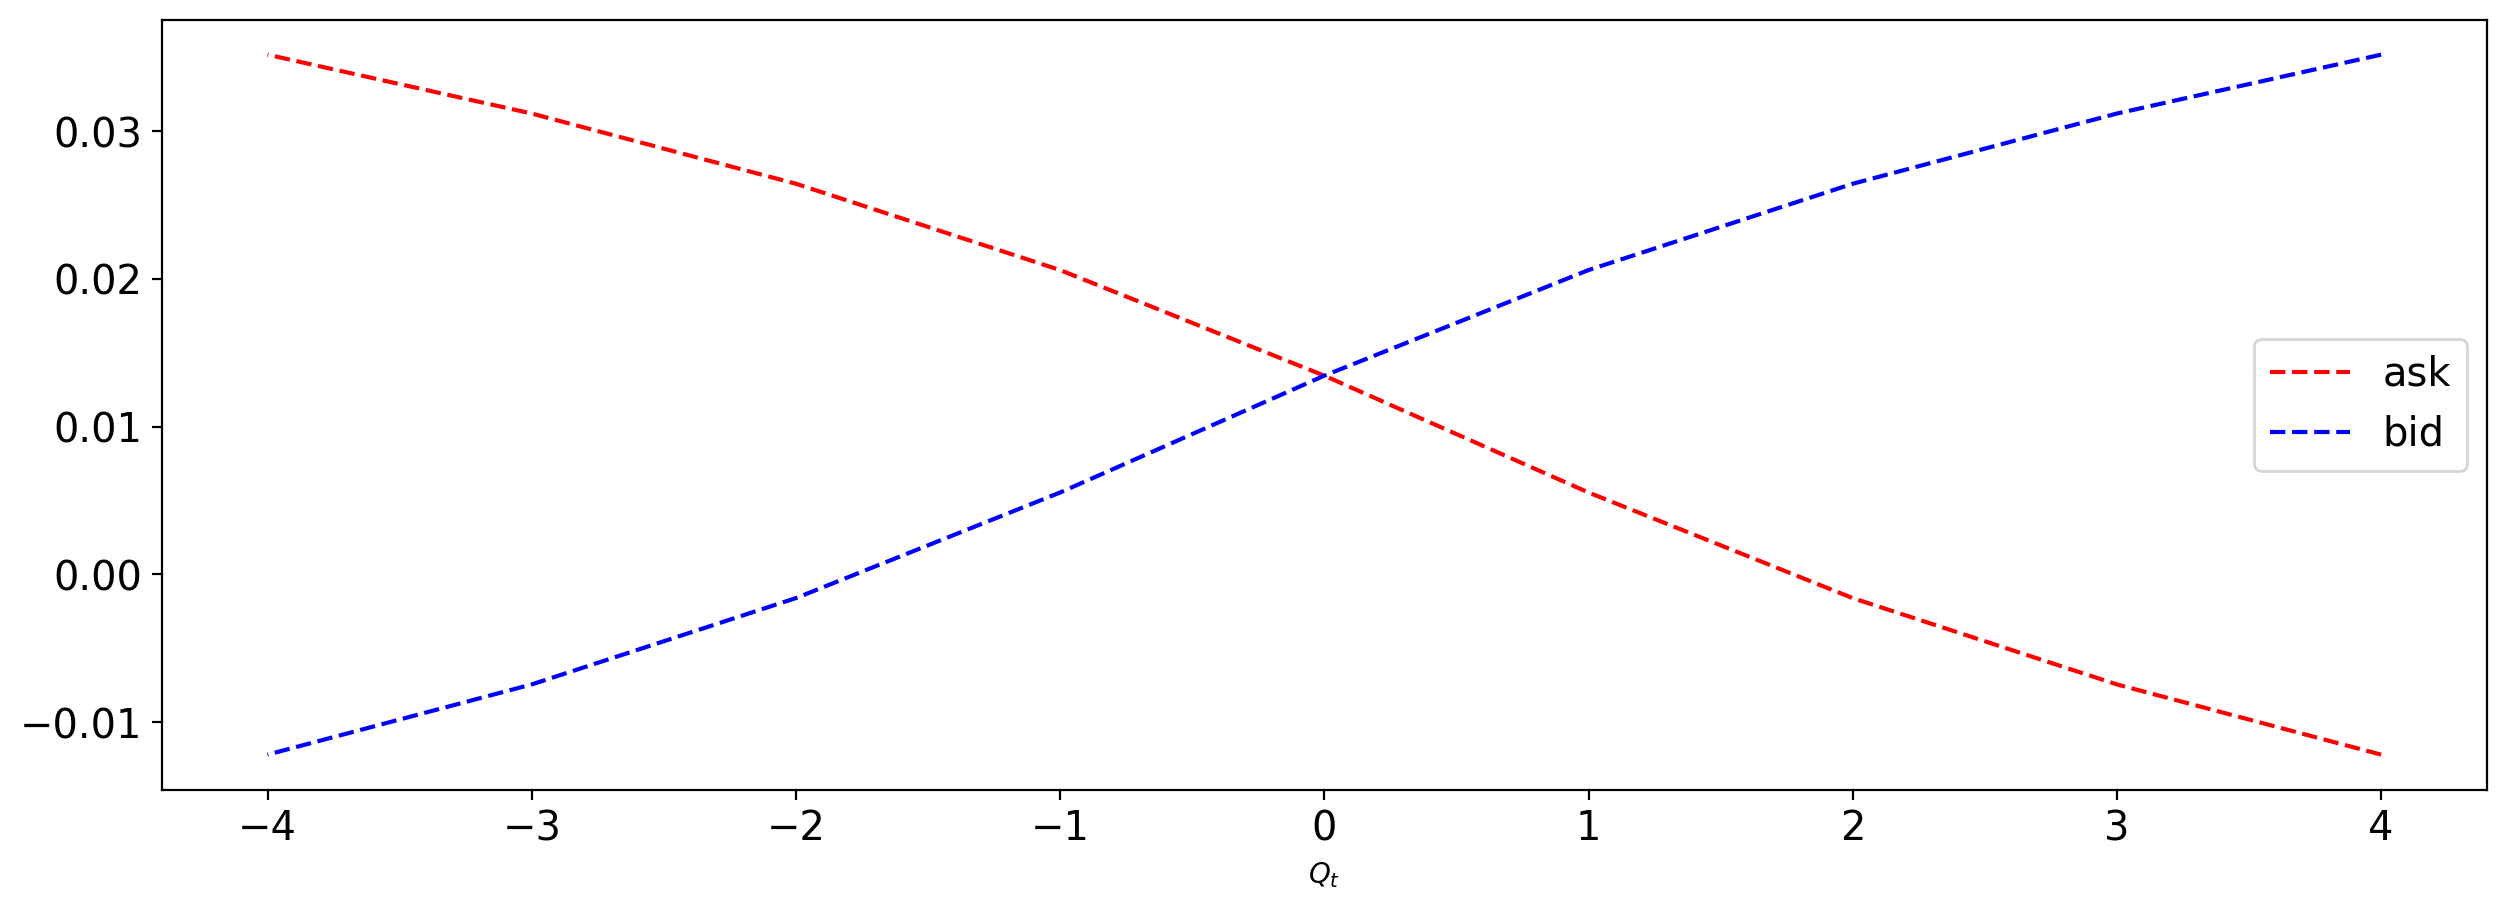

In [12]:
plt.plot(q_vector, deltas_a, 'r--')
plt.plot(q_vector, deltas_b, 'b--')
plt.xlabel(r'$Q_t$')
plt.legend(['ask','bid'])
plt.show()

In [13]:
t = 0.5
q = 0
dmax = 5
dmin = - dmax

d_plus_z_vector = np.arange(dmax-1,dmin,step=-1)

deltas_a = np.zeros((d_plus_z_vector.shape))
deltas_b = np.zeros((d_plus_z_vector.shape))

for i,d_z in enumerate(d_plus_z_vector):
    delta_a, delta_b = _calculate_deltas(t, q, d_z)
    deltas_a[i] = delta_a
    deltas_b[i] = delta_b

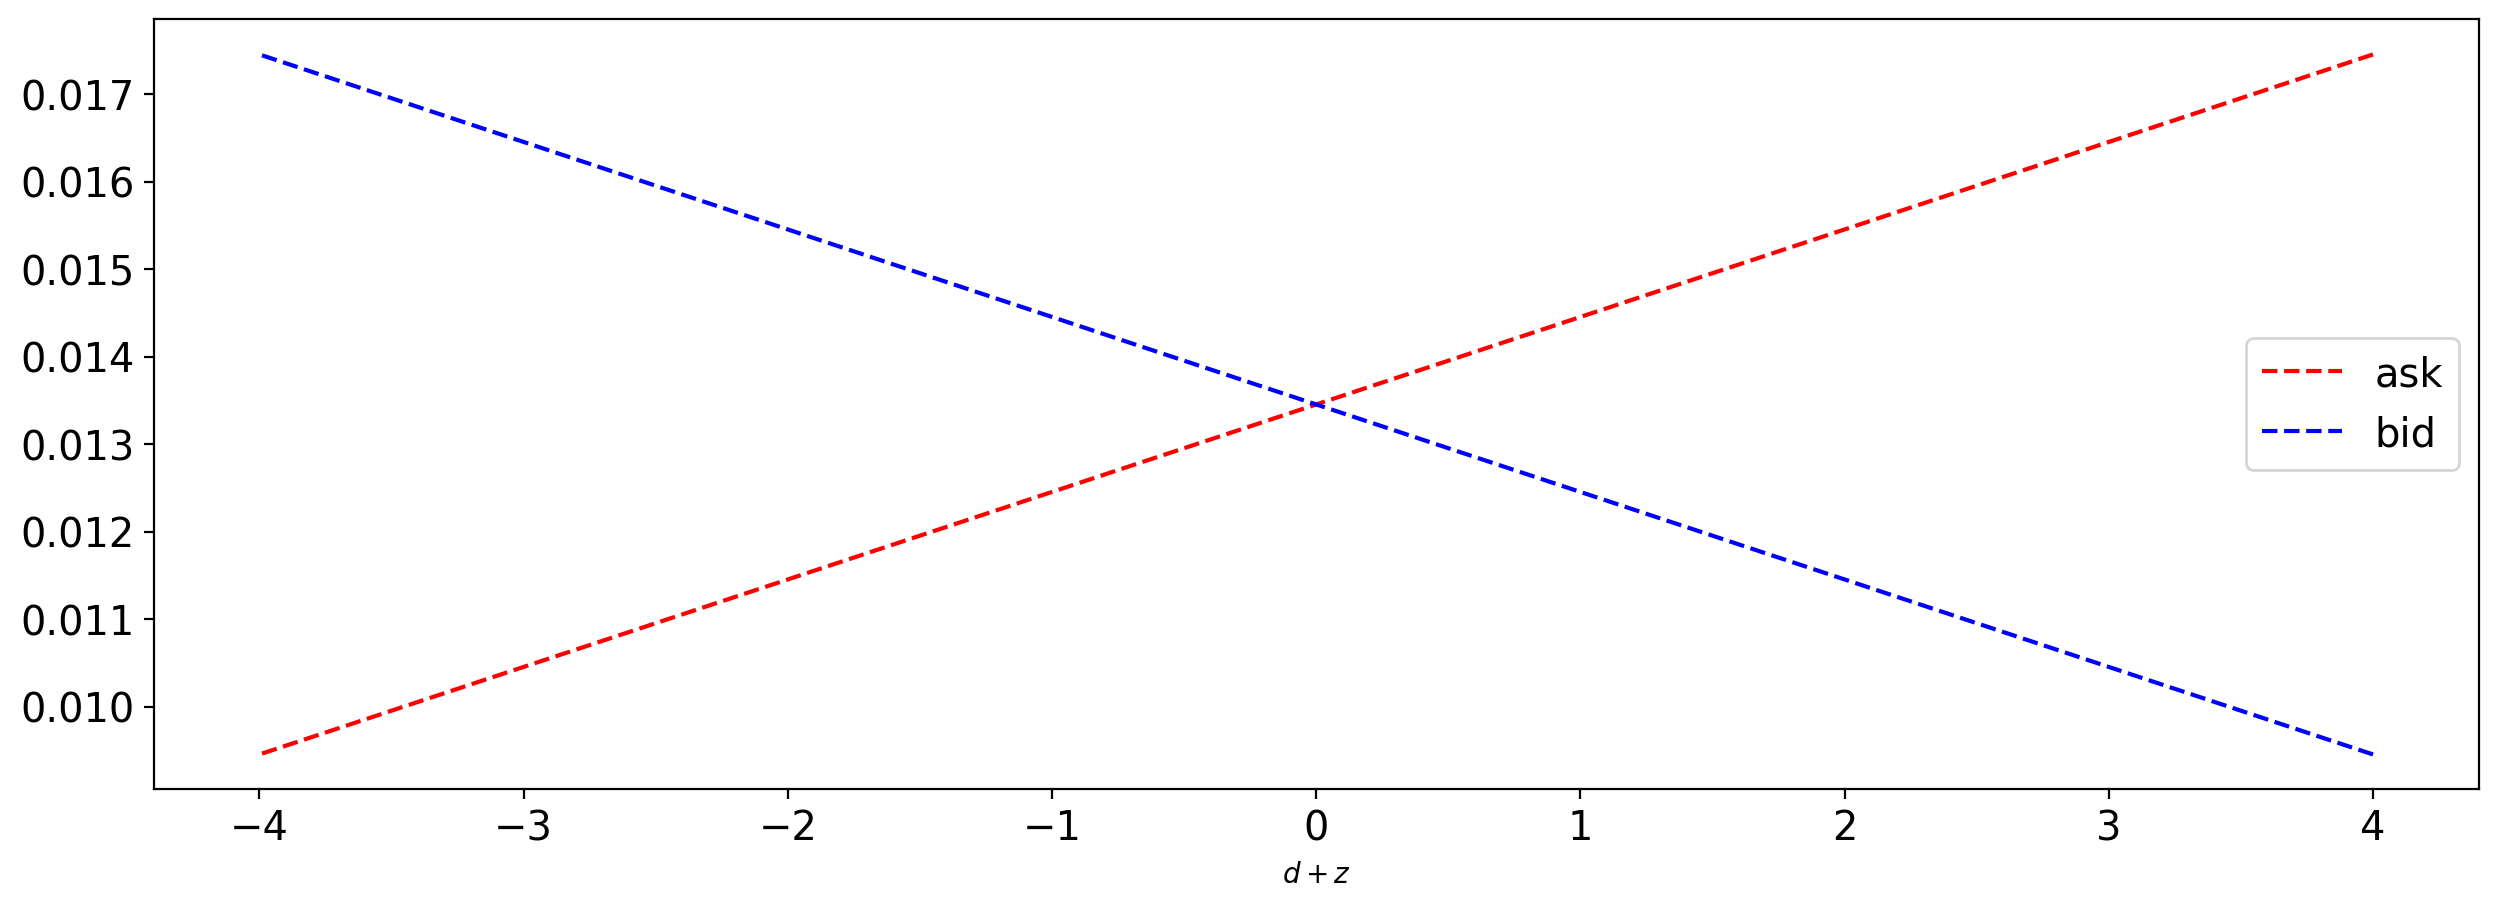

In [14]:
plt.plot(d_plus_z_vector, deltas_a, 'r--')
plt.plot(d_plus_z_vector, deltas_b, 'b--')
plt.xlabel(r'$d+z$')
plt.legend(['ask','bid'])
plt.show()

In [15]:
t_vector = np.linspace(0,T,num=100)
q_vector = np.arange(qmax-1,qmin,step=-1)

d_plus_z = 0


deltas_a = np.zeros((t_vector.shape[0],q_vector.shape[0]))
deltas_b = np.zeros((t_vector.shape[0],q_vector.shape[0]))

for it,t in enumerate(t_vector):
    for iq,q in enumerate(q_vector):
        delta_a, delta_b = _calculate_deltas(t, q, d_plus_z)
        deltas_a[it,iq] = delta_a
        deltas_b[it,iq] = delta_b

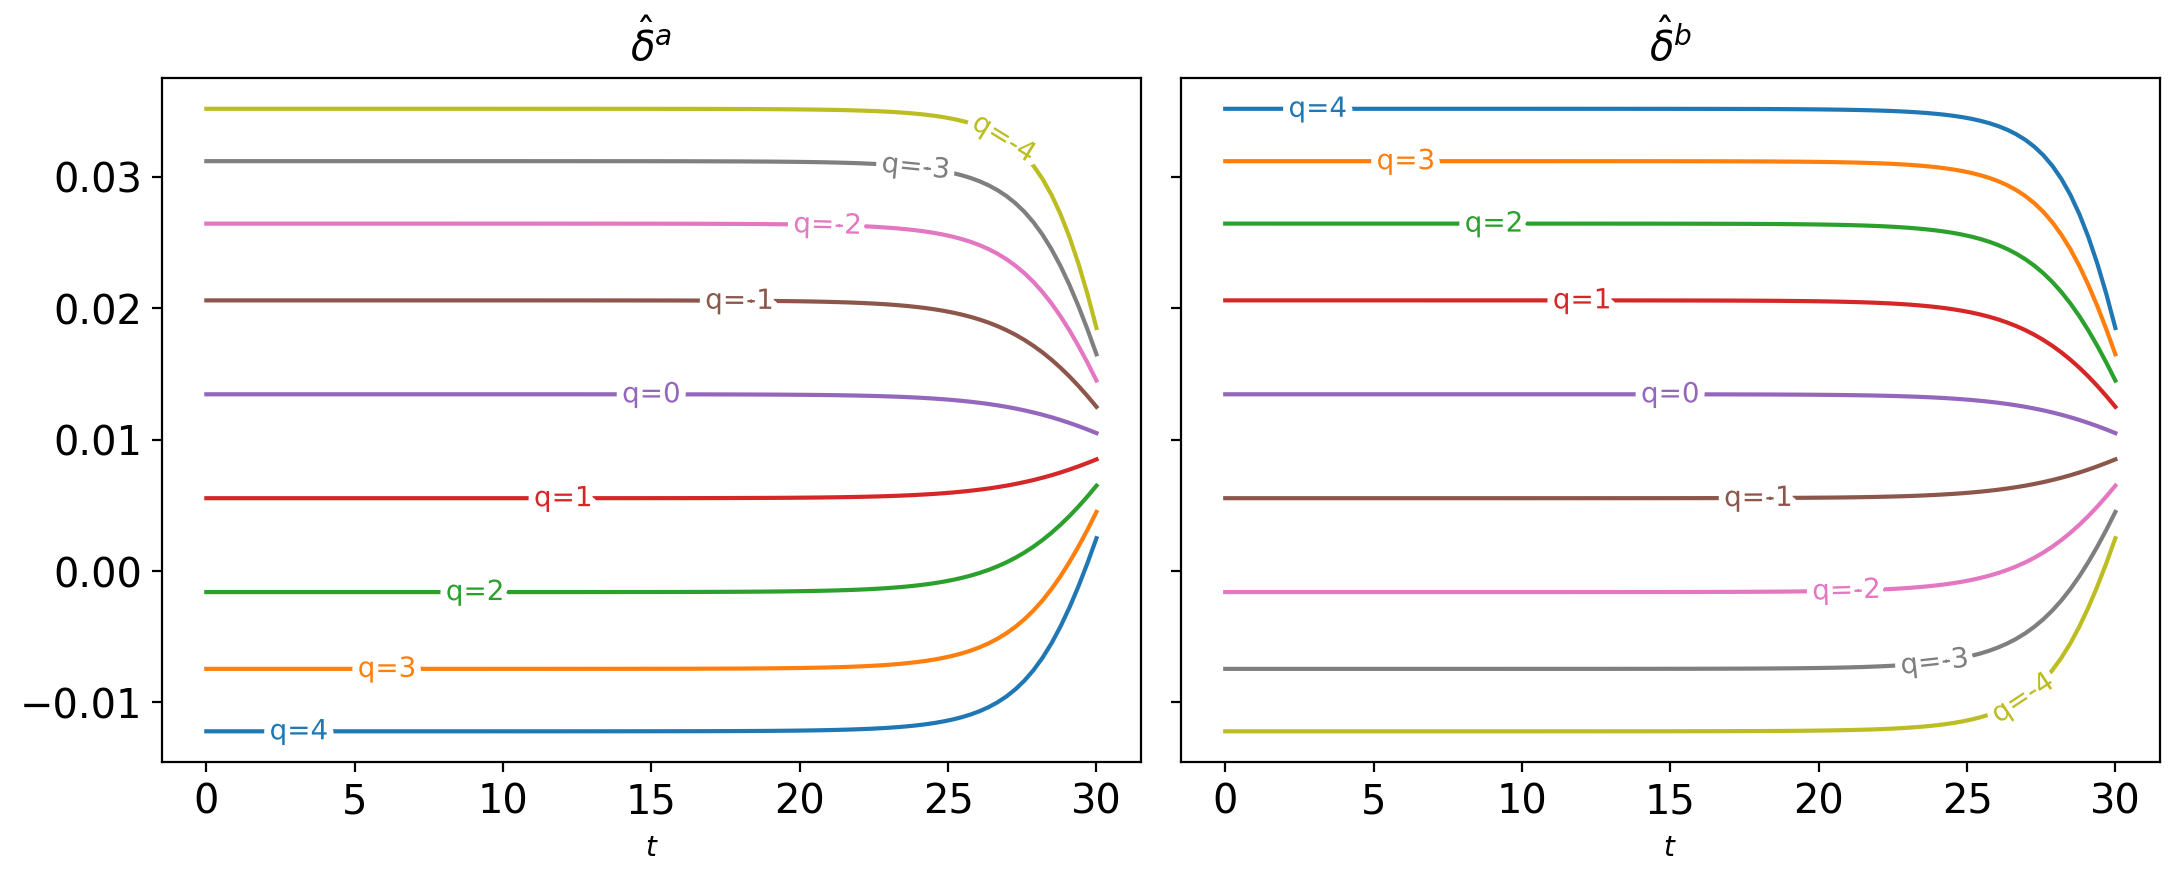

In [16]:
fig, ax = plt.subplots(1,2, figsize = (11,4.5), sharey=True)
for iq,q in enumerate(q_vector):
    ax[0].plot(t_vector, deltas_a[:,iq], label="q="+str(q))
    ax[1].plot(t_vector, deltas_b[:,iq], label="q="+str(q))
#ax[0].legend([f'q = {q}' for q in q_vector])
ax[0].set_xlabel(r'$t$')
ax[1].set_xlabel(r'$t$')
ax[0].set_title(r'$\hat{\delta}^{a}$')
ax[1].set_title(r'$\hat{\delta}^{b}$')
labelLines(ax[0].get_lines(), zorder=2.5)
labelLines(ax[1].get_lines(), zorder=2.5)
plt.tight_layout()
plt.savefig('figures/sample_path_main_processes.pdf', format="pdf", dpi=resolution_value)
plt.show()

# Experiments

In [17]:
def brownian(Nt=1000, S0=0, sigma=0.01):
    timesteps = np.linspace(0, T, Nt)
    path = np.zeros(Nt)
    path[0] = S0
    Z = rng.normal(0,1, Nt)
    for n in range(1, Nt):
        path[n] = path[n-1] + sigma * np.sqrt(T/Nt) * Z[n]
    return path

def get_arrival(sims, dt, lambda_a, lambda_b):
    unif_a = rng.uniform(size=(sims,))
    unif_b = rng.uniform(size=(sims,))
    return unif_a < 1. - np.exp(-lambda_a * dt), unif_b < 1. - np.exp(-lambda_b * dt)

In [18]:
Nt = 1000
sims = 5
dt = T/Nt

X = np.zeros((sims,Nt+1))
Q = np.zeros((sims,Nt+1))
D = np.zeros((sims,Nt+1))
S = np.zeros((sims,Nt+1))
Z = np.zeros((sims,Nt+1))
pnl = np.zeros(sims)
intQ = np.zeros(sims)
objective = np.zeros(sims)

deltas_a = np.zeros((sims, Nt+1))
deltas_b = np.zeros((sims, Nt+1))
tildes_a = np.zeros((sims, Nt+1))
tildes_b = np.zeros((sims, Nt+1))

arrivaltimes_a = np.zeros((sims, Nt+1))
arrivaltimes_b = np.zeros((sims, Nt+1))

S[:,0] = S0

time = np.linspace(0, T, Nt+1)

In [19]:
for it,t in enumerate(time[:-1]):   
    delta_a, delta_b = _calculate_deltas(t, Q[:,it], D[:,it]+Z[:,it])
    deltas_a[:, it] = delta_a[:]
    deltas_b[:, it] = delta_b[:]
    
    aux_normal = rng.normal(0, 1)
    Z[:,it+1] = Z[:,it] + sigma_Z *  np.sqrt(T/Nt) * aux_normal
    aux_normal = rng.normal(0, 1)
    S[:,it+1] = S[:,it] + sigma *  np.sqrt(T/Nt) * aux_normal
    
    arrival_a, arrival_b = get_arrival(sims, dt, lambda_a, lambda_b)
    arrivaltimes_a[:,it] = arrival_a*t
    arrivaltimes_b[:,it] = arrival_b*t
    
    fill_a = rng.uniform(size=(sims,))
    fill_b = rng.uniform(size=(sims,))
    
    delta_tilde_a = alpha_a + beta * (D[:,it] + Z[:,it])
    delta_tilde_b = alpha_b - beta * (D[:,it] + Z[:,it])
    tildes_a[:,it] = delta_tilde_a[:]
    tildes_b[:,it] = delta_tilde_b[:]
    
    prob_a = np.minimum(np.exp(-kappa*(delta_a - delta_tilde_a)),1)
    prob_b = np.minimum(np.exp(-kappa*(delta_b - delta_tilde_b)),1)
    
    filled_trade_a = (fill_a < prob_a) * (Q[:,it]!=qmin)
    filled_trade_b = (fill_b < prob_b) * (Q[:,it]!=qmax)
    
    
    Q[:,it+1] = Q[:,it] - filled_trade_a*arrival_a + filled_trade_b*arrival_b
    D[:,it+1] = D[:,it] - (1-filled_trade_a)*arrival_a + (1-filled_trade_b)*arrival_b
    
    X[:,it+1] = X[:,it] + filled_trade_a*arrival_a*(S[:,it] + delta_a) - filled_trade_b*arrival_b*(S[:,it] - delta_a)

pnl[:] = X[:,-1] + Q[:,-1]*S[:,-1]
for s in range(1, sims):
    intQ[s] = np.sum(Q[s,:]**2)/Nt
objective[:] = pnl[:] - a*Q[:,-1]**2 - phi*intQ[:]
arrivaltimes_a = arrivaltimes_a[arrivaltimes_a!=0]

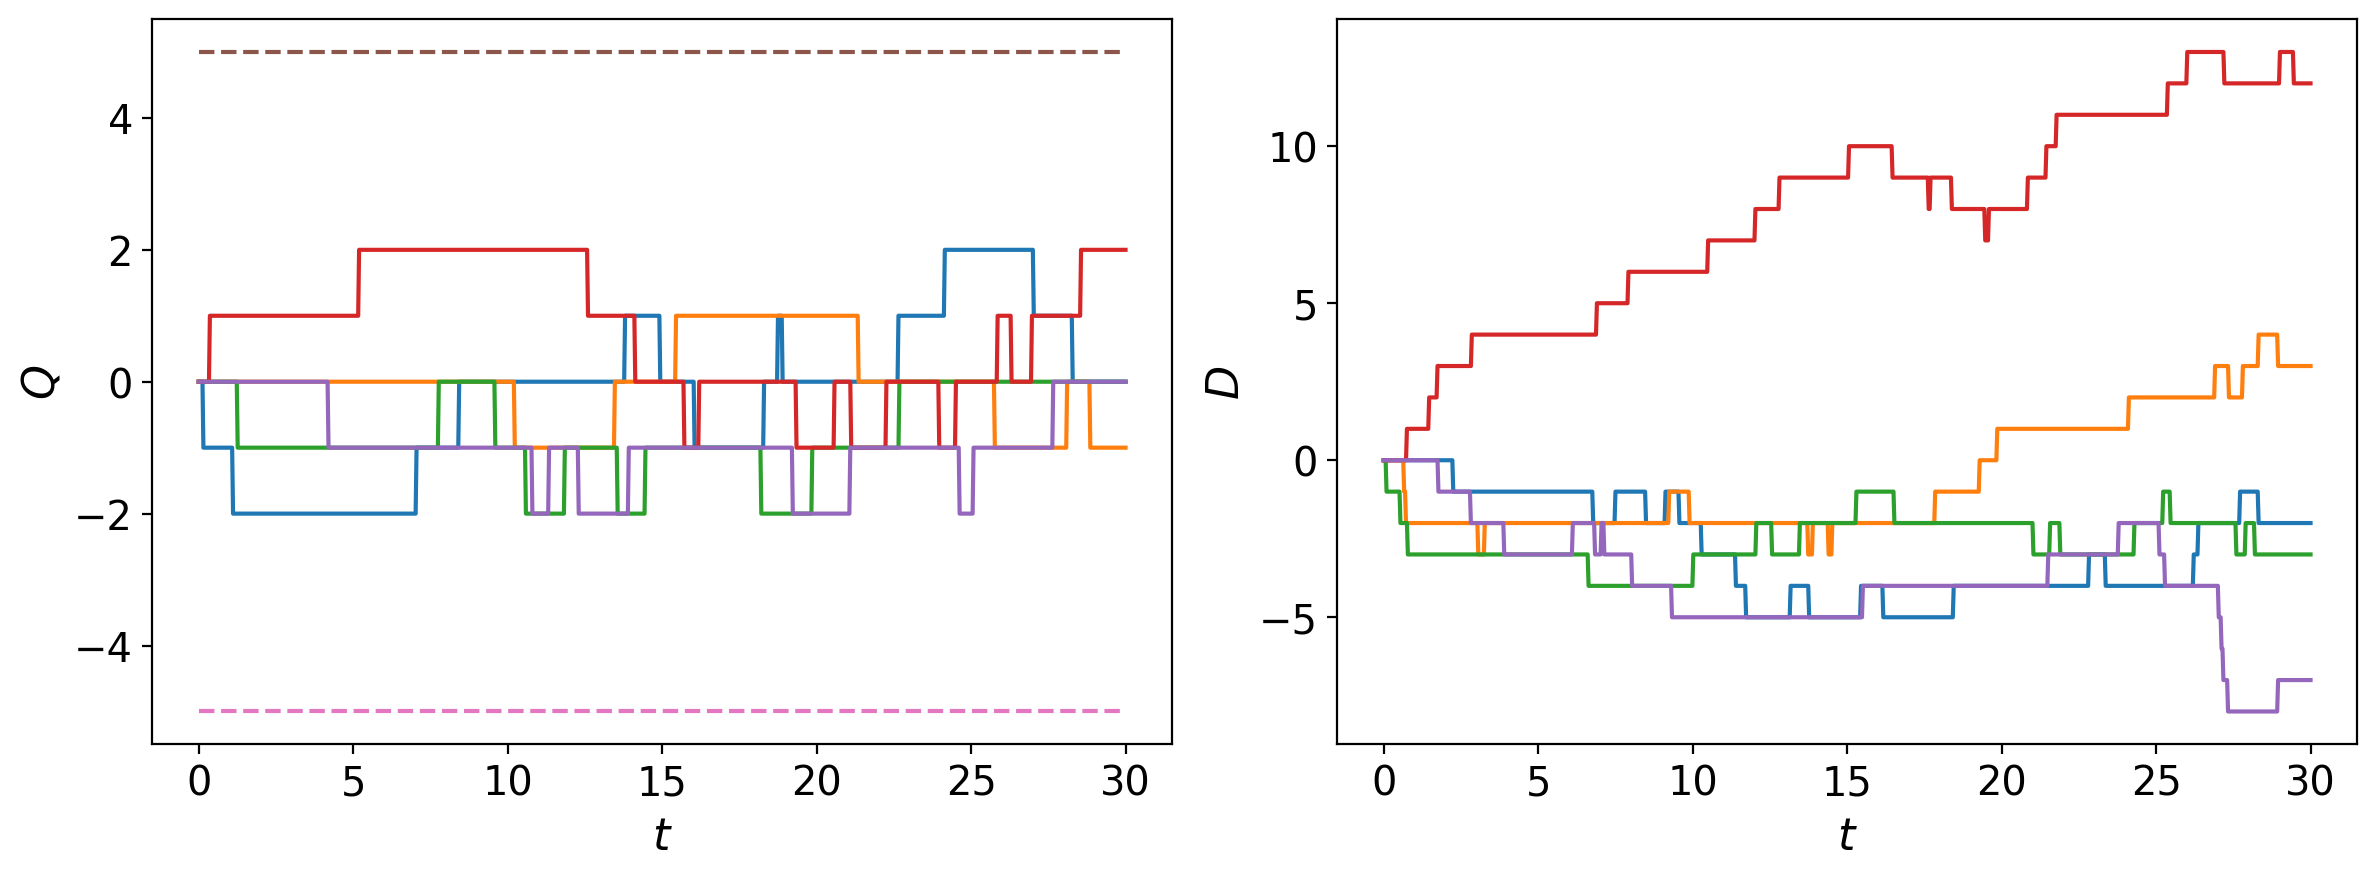

Terminal Q mean = 0.2              Terminal Q sd = 0.9798
Terminal D mean = 0.6              Terminal D sd = 6.5299
Terminal X mean = -19.737            Terminal X sd = 97.932
Terminal PnL mean = 0.2792           Terminal PnL sd = 0.1463
Terminal objective mean = 0.2773     Terminal objective sd = 0.1444


In [20]:
fig, ax = plt.subplots(1, 2, figsize = (12,4.5), sharey=False, sharex=True)
ax[0].plot(time, np.transpose(Q))
ax[1].plot(time, np.transpose(D))
ax[0].plot(time, np.repeat(qmax, len(time)), '--')
ax[0].plot(time, np.repeat(qmin, len(time)), '--')
#ax[0].set_title("Reference MM's inventory", **tnrfont)
#ax[1].set_title("Pooled competition's inventory", **tnrfont)
ax[0].set_xlabel(r'$t$', fontsize = 16)
ax[1].set_xlabel(r'$t$', fontsize = 16)
ax[0].set_ylabel(r'$Q$', fontsize = 16)
ax[1].set_ylabel(r'$D$', fontsize = 16)
plt.tight_layout()
plt.savefig('figures/inventory_processes.pdf', format="pdf", dpi=resolution_value)
plt.show()

print("Terminal Q mean = "+str(np.round(np.mean(Q[:,-1]),4))+"              Terminal Q sd = "+str(np.round(np.std(Q[:,-1]),4)))
print("Terminal D mean = "+str(np.round(np.mean(D[:,-1]),4))+"              Terminal D sd = "+str(np.round(np.std(D[:,-1]),4)))
print("Terminal X mean = "+str(np.round(np.mean(X[:,-1]),4))+"            Terminal X sd = "+str(np.round(np.std(X[:,-1]),4)))
print("Terminal PnL mean = "+str(np.round(np.mean(pnl[:]),4))+"           Terminal PnL sd = "+str(np.round(np.std(pnl[:]),4)))
print("Terminal objective mean = "+str(np.round(np.mean(objective[:]),4))+"     Terminal objective sd = "+str(np.round(np.std(objective[:]),4)))

In [21]:
# since final depths never calculated
deltas_a[:,-1] = deltas_a[:,-2]
deltas_b[:,-1] = deltas_b[:,-2]
tildes_a[:,-1] = tildes_a[:,-2]
tildes_b[:,-1] = tildes_b[:,-2]

deltas_a = np.round(deltas_a[:,:], 3)
deltas_b = np.round(deltas_b[:,:], 3)
tildes_a = np.round(tildes_a[:,:], 3) + 1e-3
tildes_b = np.round(tildes_b[:,:], 3) + 1e-3
S = np.round(S, 3)

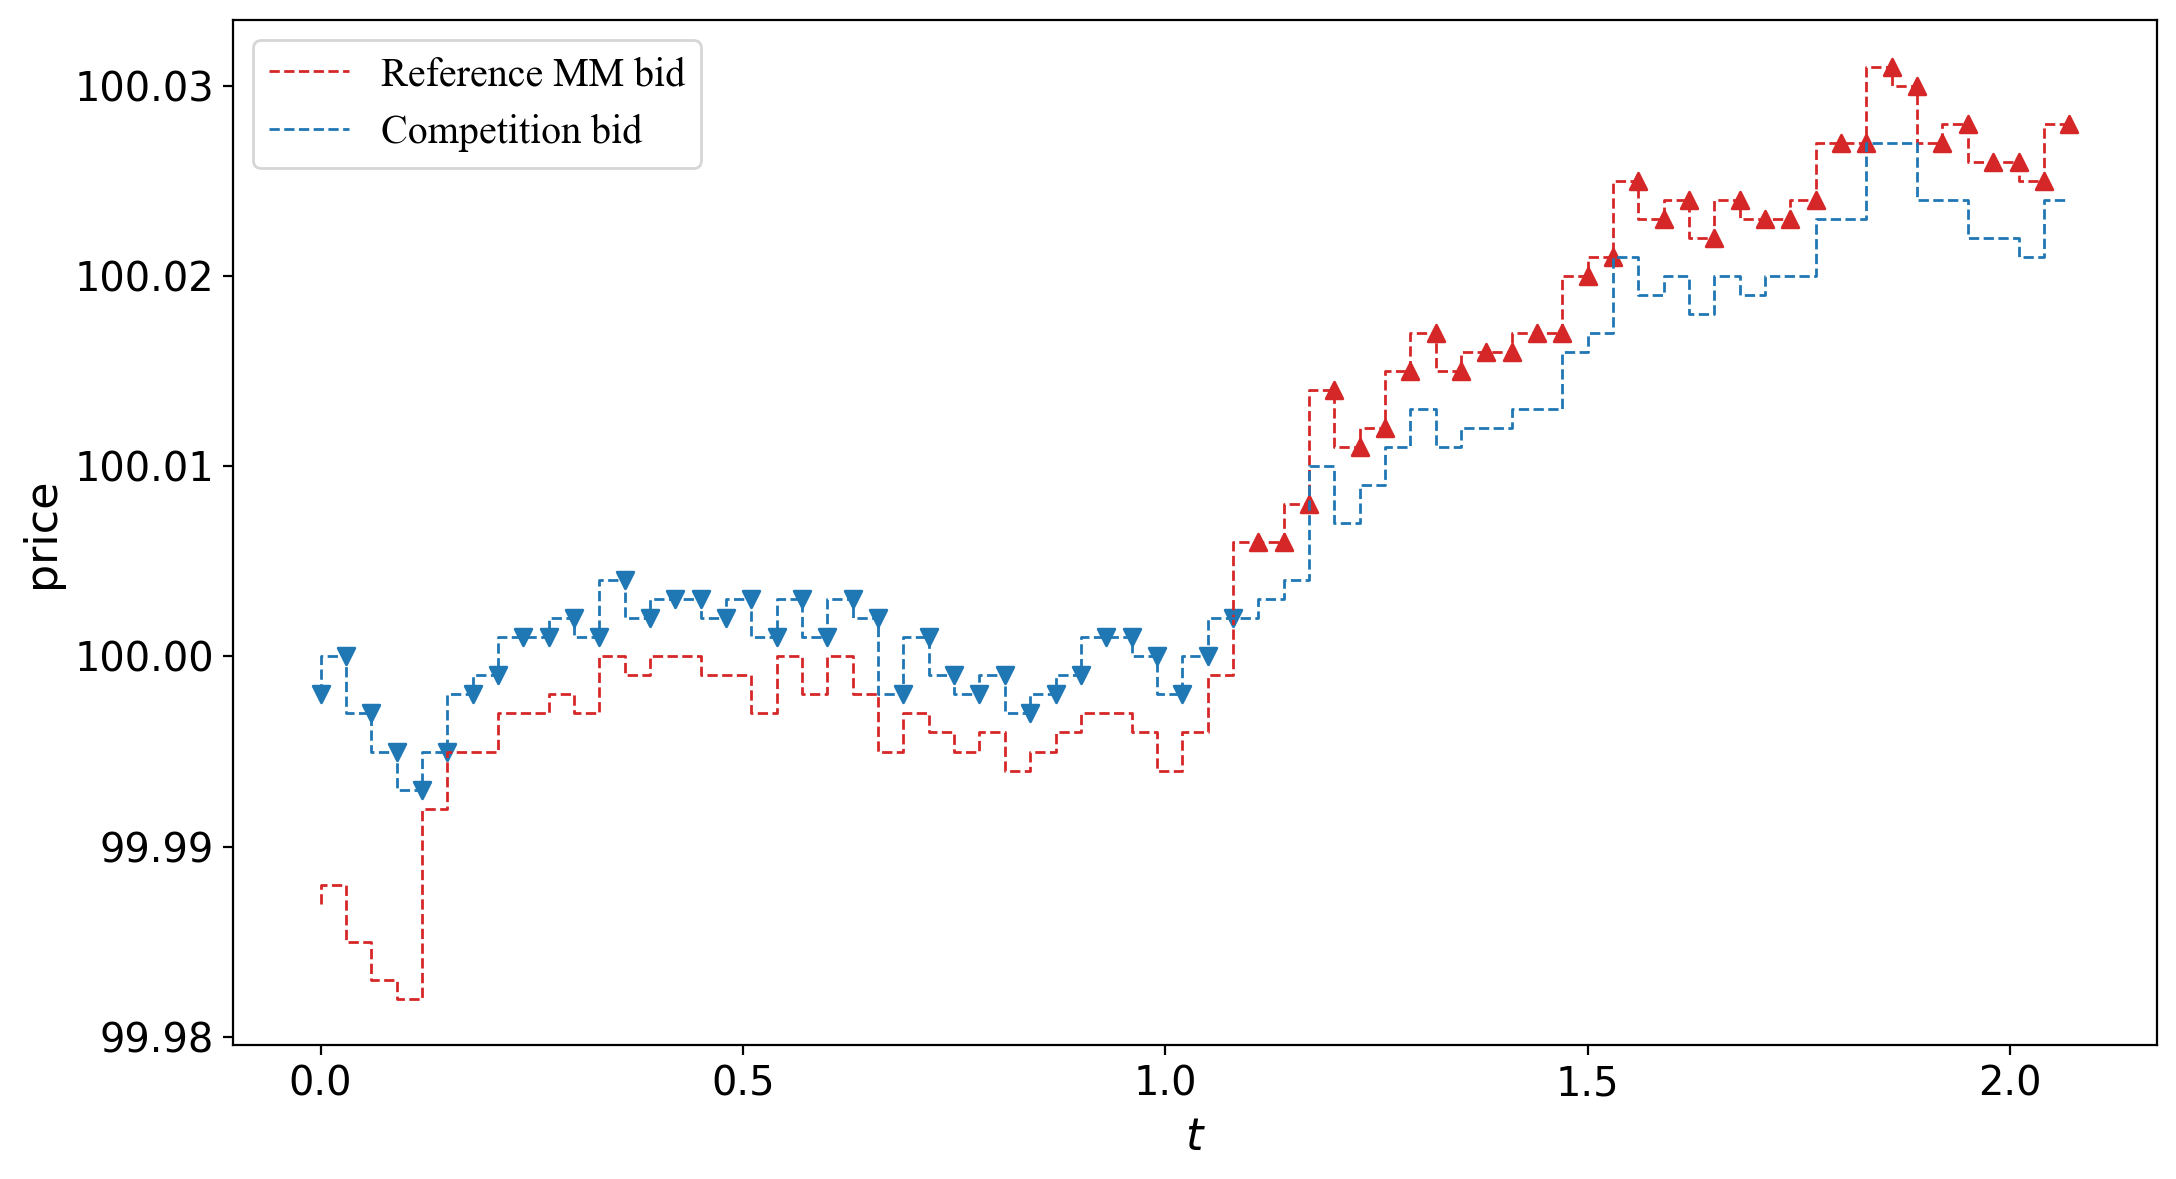

In [22]:
sim = 0
plotfrom=0
plotto = int(Nt*0.07)

time_aux = time[plotfrom:plotto]
deltas_a_aux = deltas_a[:,plotfrom:plotto]
deltas_b_aux = deltas_b[:,plotfrom:plotto]
tildes_a_aux = tildes_a[:,plotfrom:plotto]
tildes_b_aux = tildes_b[:,plotfrom:plotto]
S_aux = S[:,plotfrom:plotto]


webetter_a = np.argwhere(deltas_a_aux[sim,:] < tildes_a_aux[sim,:])
theybetter_a = np.argwhere(deltas_a_aux[sim,:] >= tildes_a_aux[sim,:])
webetter_b = np.argwhere(deltas_b_aux[sim,:] < tildes_b_aux[sim,:])
theybetter_b = np.argwhere(deltas_b_aux[sim,:] >= tildes_b_aux[sim,:])



fig, ax = plt.subplots(1, 1, figsize = (11,6), sharey=False, sharex=True)
plt.scatter(time_aux[webetter_b[:,0]], S_aux[sim,webetter_b[:,0]] - deltas_b_aux[sim,webetter_b[:,0]], marker = "^", color='tab:red')
plt.scatter(time_aux[theybetter_b[:,0]], S_aux[sim,theybetter_b[:,0]] - tildes_b_aux[sim,theybetter_b[:,0]], marker = "v", color='tab:blue')

#plt.step(time_aux, S[sim,plotfrom:plotto], linewidth=0.6, label="Unaffected", color="gold")
#plt.step(time_aux, S[sim,plotfrom:plotto]+deltas_a[sim,plotfrom:plotto], linewidth=0.8, label="Ref Ask", color="darkgreen")
plt.step(time_aux, S[sim,plotfrom:plotto]-deltas_b[sim,plotfrom:plotto], '--', linewidth=1, label="Reference MM bid", color="tab:red")
#plt.step(time_aux, S[sim,plotfrom:plotto]+tildes_a[sim,plotfrom:plotto], linewidth=0.8, label="Comp Ask", color="lawngreen")
plt.step(time_aux, S[sim,plotfrom:plotto]-tildes_b[sim,plotfrom:plotto], '--', linewidth=1, label="Competition bid", color="tab:blue")
plt.ticklabel_format(axis='y', useOffset=False)
ax.set_ylabel("price", fontsize = 16)
ax.set_xlabel(r'$t$', fontsize = 16)
#ax.set_title("Realisation of price processes", **tnrfont)
ax.legend(prop={'family':fontnm})
plt.tight_layout()
plt.savefig('figures/competition_for_TOB.pdf', format="pdf", dpi=resolution_value)
plt.show()
